<a href="https://colab.research.google.com/github/nikkernoodle/shark-id/blob/models/Efficientnet_enhanced_model_v3_augmentation%2C%20on%20sharks_tar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.random import set_seed
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm import tqdm
from PIL import Image

# PREPROCESSING

In [3]:
def load_sharks_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/shark-datasets/sharks_tar'
    elif loading_method == 'direct':
        data_path = '../raw_data/sharks/'
    classes = {'basking': 0, 'blue': 1, 'hammerhead': 2, 'mako': 3, 'sand tiger': 4, 'tiger': 5, 'white' : 6,
               'blacktip': 7 , 'bull': 8, 'lemon':9 , 'nurse': 10, 'thresher': 11, 'whale': 12, 'whitetip': 13}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl))]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((224, 224))
                image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.RandomState(seed=42).permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_sharks_data("colab")

100%|██████████| 124/124 [00:07<00:00, 16.23it/s]


In [5]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((973, 224, 224, 3),
 (973, 14),
 (306, 224, 224, 3),
 (306, 14),
 (255, 224, 224, 3),
 (255, 14))

# Augmentation

In [6]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = (0.8, 1.2),
    preprocessing_function=preprocess_input
    )

datagen.fit(X_train)
datagen

## Apply to dataset

In [7]:
train_flow = datagen.flow(X_train, y_train, batch_size=16)

# MODEL

## Define model

In [8]:
def load_model():

    model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    return model


In [9]:
model = load_model()
# model.summary()

43941136/43941136 [==============================] - 0s 0us/step


In [10]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [11]:
model = set_nontrainable_layers(model)
# model.summary()

### Actually build the model

In [12]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu', kernel_regularizer=regularizers.L1(0.0001))
    dropout_layer1 = layers.Dropout(0.3)
    dense_layer2 = layers.Dense(400, activation='relu', kernel_regularizer=regularizers.L1(0.0001))
    dropout_layer2 = layers.Dropout(0.3)
    dense_layer3 = layers.Dense(300, activation='relu', kernel_regularizer=regularizers.L1(0.0001))
    dropout_layer3 = layers.Dropout(0.3)
    prediction_layer = layers.Dense(14, activation='softmax')
#creating dense layer 1 (changed from 50 to 500), dense layer 2 (400) and dense layer 3 (300) and dropout layers

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dropout_layer1,
        dense_layer2,
        dropout_layer2,
        dense_layer3,
        dropout_layer3,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [13]:
model = add_last_layers(model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 75264)             0         
                                                                 
 dense (Dense)               (None, 500)               37632500  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               200400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               1

## Compile EfficientnetB2 + layers

In [14]:
def build_model():

    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  weighted_metrics=['accuracy'])

    return model


## Fit the model

In [15]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 flatten_1 (Flatten)         (None, 75264)             0         
                                                                 
 dense_4 (Dense)             (None, 500)               37632500  
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 400)               200400    
                                                                 
 dropout_4 (Dropout)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 300)              

In [16]:
set_seed(42)
model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)
#patience changes from 5 to 20
history = model.fit(train_flow,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[es])
#patience changes from 50 to 100
#batch_size changed from 16 to 32

Epoch 1/100
61/61 [==============================] - 42s 339ms/step - loss: 20.3452 - accuracy: 0.1891 - val_loss: 18.8867 - val_accuracy: 0.4020
Epoch 2/100
61/61 [==============================] - 14s 224ms/step - loss: 18.4689 - accuracy: 0.3474 - val_loss: 17.3619 - val_accuracy: 0.4967
Epoch 3/100
61/61 [==============================] - 13s 221ms/step - loss: 16.9770 - accuracy: 0.3823 - val_loss: 15.8614 - val_accuracy: 0.5523
Epoch 4/100
61/61 [==============================] - 14s 227ms/step - loss: 15.5436 - accuracy: 0.4409 - val_loss: 14.5093 - val_accuracy: 0.5621
Epoch 5/100
61/61 [==============================] - 14s 220ms/step - loss: 14.2860 - accuracy: 0.4882 - val_loss: 13.2979 - val_accuracy: 0.6797
Epoch 6/100
61/61 [==============================] - 13s 218ms/step - loss: 13.1087 - accuracy: 0.5416 - val_loss: 12.3302 - val_accuracy: 0.6438
Epoch 7/100
61/61 [==============================] - 14s 224ms/step - loss: 12.1118 - accuracy: 0.5735 - val_loss: 11.3503 -

### Plot accuracy

In [17]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

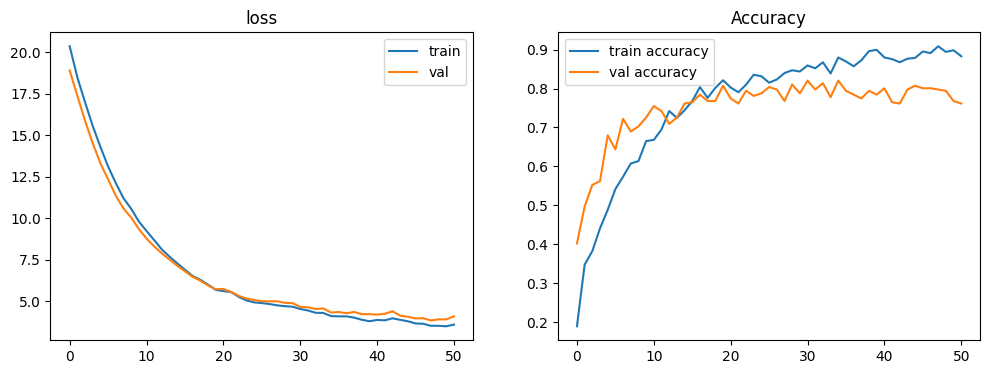

In [18]:
plot_history(history)

In [19]:
#overall accuarcy

res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

# print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')


8/8 [==============================] - 3s 269ms/step - loss: 4.8019 - accuracy: 0.7569
test_accuracy_vgg = 76.0 %
Chance level: 7.1%


In [20]:
predictions = model.predict(X_test)

8/8 [==============================] - 3s 110ms/step


In [21]:
y_pred = []

for pred in predictions:
  y_pred.append(np.argmax(pred))

In [22]:
y_test_argmax = []
for test in y_test:
  y_test_argmax.append(np.argmax(test))

### Classification Report for each class and overall

#### Create accuracy metric

In [23]:
# Return macro accuracy
accuracy = accuracy_score(y_test_argmax, y_pred)

# Return weighted accuracy
accuracy_bal = balanced_accuracy_score(y_test_argmax, y_pred)

accuracy, accuracy_bal

(0.7568627450980392, 0.761099216401074)

In [24]:
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics

In [25]:
#classification report

labels=['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

report = classification_report(y_test_argmax, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     basking       0.89      0.94      0.91        17
        blue       0.67      0.80      0.73        15
  hammerhead       1.00      1.00      1.00        19
        mako       0.71      0.89      0.79        19
  sand tiger       0.50      0.73      0.59        11
       tiger       0.67      0.56      0.61        18
       white       0.64      0.67      0.65        21
    blacktip       0.72      0.87      0.79        15
        bull       0.70      0.37      0.48        19
       lemon       0.60      0.62      0.61        24
       nurse       0.75      0.75      0.75        16
    thresher       0.95      0.86      0.90        22
       whale       1.00      0.82      0.90        17
    whitetip       0.85      0.77      0.81        22

    accuracy                           0.76       255
   macro avg       0.76      0.76      0.75       255
weighted avg       0.77      0.76      0.75       255



In [26]:
#classification report
##note that this also ranks accuracy, weight avg and macroavg, so these can be ignored (and taken from the table above)

report = classification_report(y_test_argmax, y_pred, target_names=labels, output_dict=True)

# Convert the report to a pandas DataFrame
df = pd.DataFrame(report).transpose()
df = df.sort_values(by='f1-score', ascending=False)
df.reset_index(inplace=True)
df

,index,precision,recall,f1-score,support
0,hammerhead,1.000000,1.000000,1.000000,19.000000
1,basking,0.888889,0.941176,0.914286,17.000000
2,thresher,0.950000,0.863636,0.904762,22.000000
3,whale,1.000000,0.823529,0.903226,17.000000
4,whitetip,0.850000,0.772727,0.809524,22.000000
5,mako,0.708333,0.894737,0.790698,19.000000
6,blacktip,0.722222,0.866667,0.787879,15.000000
7,accuracy,0.756863,0.756863,0.756863,0.756863
8,weighted avg,0.766927,0.756863,0.754239,255.000000
9,macro avg,0.759939,0.761099,0.752319,255.000000


### Confusion Matrix for class analysis

In [27]:
cm = confusion_matrix(y_test_argmax, y_pred)

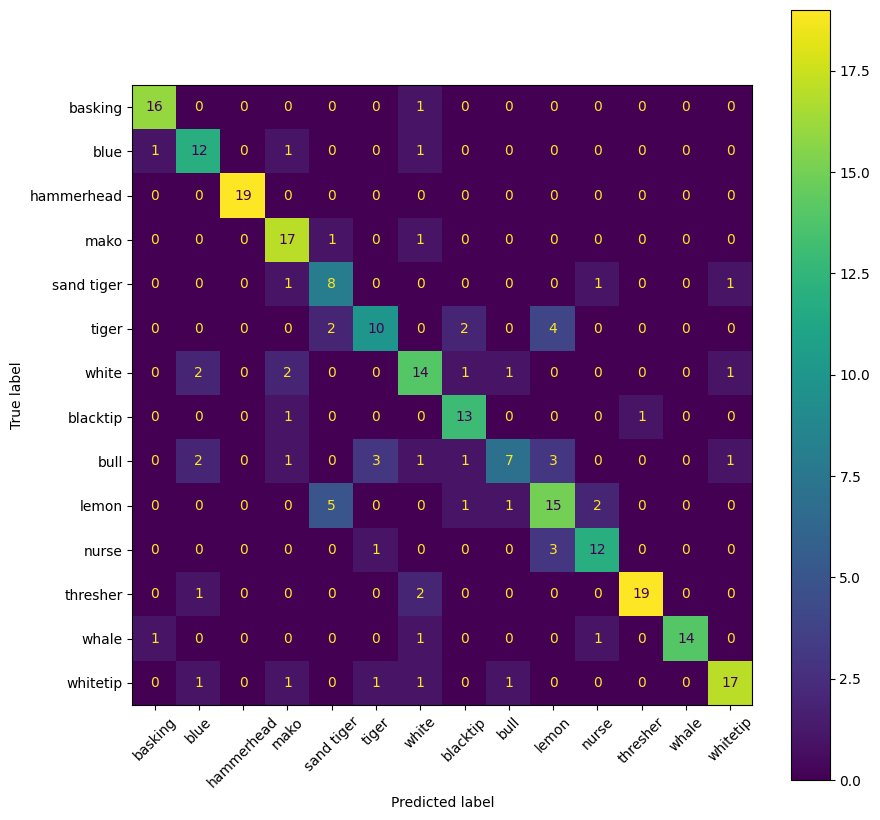

In [28]:
shark_labels = ['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=shark_labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.set_xticklabels(shark_labels, rotation=45)

plt.show()